In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import sys
import numpy as np
from tqdm import tqdm
import pymaster as nmt
from pixell import enmap
from pixell.reproject import map2healpix
sys.path.append('../../')

In [20]:
%load_ext autoreload
%autoreload 2
from cobi.simulation import Noise, Mask
from cobi.utils import change_coord
from cobi.simulation import CMB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dir = '/global/cfs/cdirs/sobs/cosmic_birefringence/v0'
nside = 2048
lmax = 5400

In [21]:
cmb_const = CMB(dir,nside=2048,model='iso',beta=0.35,lensing=True,verbose=True)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic(constant) cosmic birefringence model selected


In [4]:
LatMask = Mask(dir,nside,'LAT',apo_scale=1)

Mask : INFO - Upgrading mask LAT resolution
Mask : INFO - Apodizing mask: scale 1: method: C2
Mask : INFO - Apodizing changed the fsky 0.639 -> 0.631


In [5]:
mask = LatMask.mask

In [6]:
ncur = Noise(nside=2048,fsky=LatMask.fsky,telescope='LAT',sim='NC',atm_noise=True,nsplits=1)

Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1


In [7]:
n95 = ncur.atm_noise_maps_freq(0,'93-1')
n145 = ncur.atm_noise_maps_freq(0,'145-1')

In [8]:
wrk = nmt.NmtWorkspace()
mask_f = nmt.NmtField(mask, [mask, mask], lmax=lmax, purify_b=False)
binInfo = nmt.NmtBin.from_lmax_linear(lmax, 10)
wrk.compute_coupling_matrix(mask_f, mask_f, binInfo)

def compute_master(f_a,f_b):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wrk.decouple_cell(cl_coupled)
    return cl_decoupled
    
b = binInfo.get_effective_ells()

In [9]:
f93_cur = nmt.NmtField(mask, [n95,n95],lmax=lmax, purify_b=False)
f145_cur = nmt.NmtField(mask, [n145,n145],lmax=lmax, purify_b=False)


In [10]:
ee93_cur,e93_cur,_,bb93_cur = compute_master(f93_cur,f93_cur)
ee145_cur,e145_cur,_,bb145_cur = compute_master(f145_cur,f145_cur)

In [11]:
fdir = '/global/cfs/cdirs/sobs/v4_sims/mbs/mbs_s0015_20240504/sims'
fname= 'so_lat_mbs_mss0002_fdw_mf_mf_f090_mf_f150_lmax5400_4way_set1_noise_sim_map0000.fits'
fpath = fdir + '/' + fname

In [12]:
_todn90 = enmap.read_map(fpath,sel=np.s_[0, 0])
_todn145 = enmap.read_map(fpath,sel=np.s_[1, 0])
n90_tod = map2healpix(_todn90, nside=2048)[1:]
n145_tod = map2healpix(_todn145, nside=2048)[1:]
n90_tod = change_coord(n90_tod)
n145_tod = change_coord(n145_tod)

In [13]:
f90_tod = nmt.NmtField(mask, n90_tod,lmax=lmax, purify_b=False)
f145_tod = nmt.NmtField(mask, n145_tod,lmax=lmax, purify_b=False)

In [14]:
ee93_tod,eb93_tod,_,bb93_tod = compute_master(f90_tod,f90_tod)
ee145_tod,eb145_tod,_,bb145_tod = compute_master(f145_tod,f145_tod)

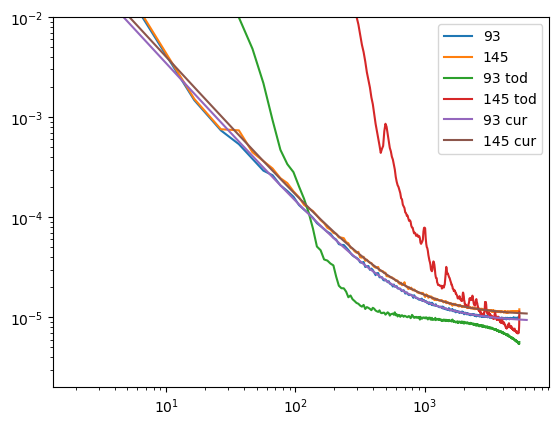

In [17]:
plt.loglog(b,bb93_cur,label='93')
plt.loglog(b,bb145_cur,label='145')
plt.loglog(b,bb93_tod/4,label='93 tod')
plt.loglog(b,bb145_tod/4,label='145 tod')
plt.loglog(ncur.Nell['ell'], ncur.Nell['93'], label='93 cur')
plt.loglog(ncur.Nell['ell'], ncur.Nell['145'], label='145 cur')
plt.ylim(None,1e-2)
plt.legend()

In [22]:
eb_signal = cmb_const.get_cb_lensed_spectra(beta=0.35,dl=False)['eb']

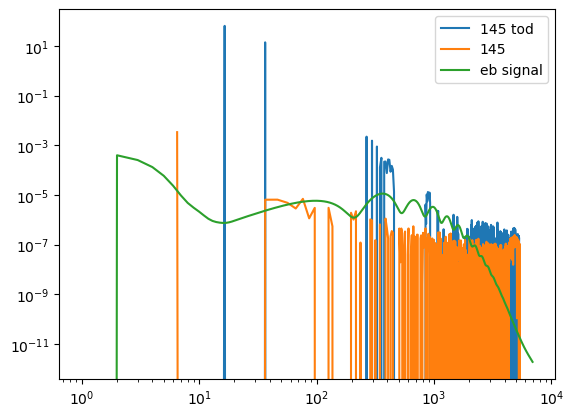

In [26]:
#plt.loglog(b,e93_cur,label='93')
#plt.loglog(b,eb93_tod,label='93 tod')
plt.loglog(b,eb145_tod,label='145 tod')
plt.loglog(b,e145_cur,label='145')
plt.loglog(eb_signal,label='eb signal')
plt.legend()